In [1]:
import os
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
import numpy as np
import pandas as pd
from pyscf import lib, gto, scf
import pyqmc.recipes
import h5py
import matplotlib.pyplot as plt

/opt/homebrew/Caskroom/miniforge/base/envs/python3.9/lib/python3.9/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


This function computes the mean-field solution and saves the results to the file specified. We recommend using the ccecp pseudopotentials for high accuracy and efficiency.

In [2]:
def mean_field(chkfile):
    mol = gto.M(atom = "O 0 0 0; H 0 -2.757 2.587; H 0 2.757 2.587", basis='ccecpccpvdz', ecp='ccecp', unit='bohr')

    mf = scf.RHF(mol)
    mf.chkfile = chkfile
    mf.kernel()
mean_field("h2o.hdf5")

converged SCF energy = -16.4791748386415


Now we wish to construct a Slater-Jastrow wave function and optimize its energy. This is done using the OPTIMIZE function in pyqmc.recipes. It's often helpful to do the first optimization with only a few configurations, to get close to the minimum cheaply.

In [3]:
pyqmc.recipes.OPTIMIZE("h2o.hdf5","h2o_sj_200.hdf5",nconfig=200,max_iterations=10,verbose=True)

starting warmup
-vmc done
finished warmup
----------vmc done
descent en -16.505134786292388 0.01578018843148801  estimated sigma  2.2316556496613362
descent |grad| 0.6121564323830218
----------vmc done
descent en -16.634486652853656 0.012137668746844028  estimated sigma  1.7165255757378874
descent |grad| 0.28358985143156035
----------vmc done
descent en -16.678992846752237 0.01055368097122634  estimated sigma  1.492515876246715
descent |grad| 0.17954897922741048
----------vmc done
descent en -16.710802291994135 0.006745288942527805  estimated sigma  0.9539279104648096
descent |grad| 0.1307409136747286
----------vmc done
descent en -16.72136113575335 0.007063835617550223  estimated sigma  0.9989772132713653
descent |grad| 0.1348263571635106
----------vmc done
descent en -16.749786459780164 0.005309205677410417  estimated sigma  0.7508350674422049
descent |grad| 0.09152907798464745
----------vmc done
descent en -16.734201622523127 0.009066279528371562  estimated sigma  1.2821655469288613

* Since we want to start from the previous optimization, we use the `load_parameters` command in OPTIMIZE.

* `max_iterations` reduces the number of iterations, just to keep the computation low for this example.

In [4]:
pyqmc.recipes.OPTIMIZE("h2o.hdf5","h2o_sj_800.hdf5", load_parameters="h2o_sj_200.hdf5", nconfig=800, max_iterations=10,verbose=True)

starting warmup
-vmc done
finished warmup
----------vmc done
descent en -16.749798810144394 0.0020843040790710127  estimated sigma  0.5895302193463581
descent |grad| 0.0911009066473086
----------vmc done
descent en -16.75143964377371 0.0040777398954018225  estimated sigma  1.1533590127814208
descent |grad| 0.07422620898475603
----------vmc done
descent en -16.745530672985446 0.0023443745394886  estimated sigma  0.6630892538053914
descent |grad| 0.053066246820785236
----------vmc done
descent en -16.758002763017224 0.0027682704786784924  estimated sigma  0.7829851310528368
descent |grad| 0.04038581451506069
----------vmc done
descent en -16.75441920442984 0.0036570473050522878  estimated sigma  1.0343691794089847
descent |grad| 0.036205936583448006
----------vmc done
descent en -16.753623245507068 0.0028704812050717727  estimated sigma  0.8118946901499133
descent |grad| 0.03673295332754831
----------vmc done
descent en -16.75146982348889 0.004247378854204815  estimated sigma  1.20134015

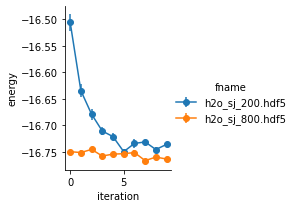

In [5]:
import seaborn as sns
df = pd.concat([pyqmc.recipes.read_opt(f"h2o_sj_{n}.hdf5") for n in [200,800]])
g = sns.FacetGrid(hue='fname',data=df)
g.map(plt.errorbar,'iteration','energy','error', marker='o')
g.add_legend()

In [6]:
for n in [200,800]:
    pyqmc.recipes.VMC("h2o.hdf5",f"h2o_sj_vmc_{n}.hdf5", load_parameters=f"h2o_sj_{n}.hdf5", nblocks=10,verbose=True)

----------vmc done
----------vmc done


                 fname  warmup reblock  energyecp  energyecp_err   energyee  \
0  h2o_sj_vmc_200.hdf5       1    None   1.178037       0.024341  14.074858   
1  h2o_sj_vmc_800.hdf5       1    None   1.164538       0.017156  14.076055   

   energyee_err   energyei  energyei_err  energygrad2  energygrad2_err  \
0      0.026596 -47.346404      0.079333    24.396090         0.425304   
1      0.018619 -47.606652      0.041409    24.921935         1.017585   

    energyke  energyke_err  energytotal  energytotal_err  nconfig  
0  12.005693      0.055584   -16.732436         0.005243      200  
1  12.255601      0.035713   -16.755079         0.003534      800  


Text(0, 0.5, 'energy (Ha)')

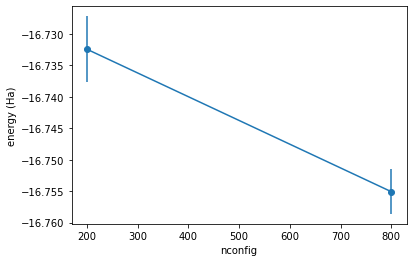

In [7]:

df = pd.DataFrame([pyqmc.recipes.read_mc_output(f"h2o_sj_vmc_{n}.hdf5") for n in [200,800]])
df['nconfig'] = [int(x.split('_')[3].replace('.hdf5','')) for x in df['fname']]
print(df)
plt.errorbar("nconfig","energytotal","energytotal_err", data=df, marker='o')
plt.xlabel("nconfig")
plt.ylabel("energy (Ha)")

In [8]:
pyqmc.recipes.DMC("h2o.hdf5",f"h2o_sj_dmc_800.hdf5", load_parameters=f"h2o_sj_800.hdf5", verbose=True)


1028 e_trial -16.82661103804481 e_est -16.81809998308422 sigma(w) 0.026679708457009926
energy -16.845370516434713 e_trial -16.82939758945285 e_est -16.81993169422638 sigma(w) 0.029082169321192498
energy -16.85241201576345 e_trial -16.83368858327845 e_est -16.823579476349042 sigma(w) 0.028426375131660162
energy -16.833937201597884 e_trial -16.834361007200215 e_est -16.82423170656497 sigma(w) 0.02727640242715205
energy -16.843102583751005 e_trial -16.835423550181098 e_est -16.82534914060987 sigma(w) 0.02634462426120148
energy -16.848238179243946 e_trial -16.837262063396793 e_est -16.826629406341485 sigma(w) 0.02651327495565397
energy -16.84887964839369 e_trial -16.83968412709693 e_est -16.828626186138212 sigma(w) 0.02838351286777383
energy -16.834103628102365 e_trial -16.839691930134517 e_est -16.828916266020855 sigma(w) 0.027125226953245096
energy -16.835890605314738 e_trial -16.83970222691996 e_est -16.82926693216103 sigma(w) 0.026940892538267272
energy -16.86675227544422 e_trial -16.8

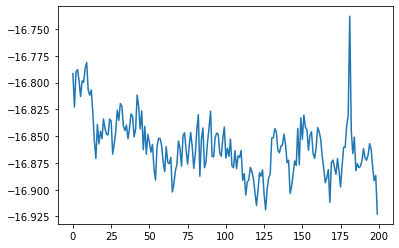

In [9]:
with h5py.File("h2o_sj_dmc_800.hdf5") as f:
    en = f['energytotal'][...]

plt.plot(en)


Text(0.5, 0, 'warmup')

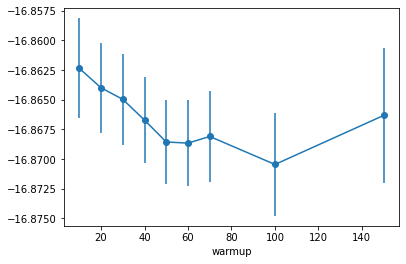

In [10]:
df = pd.DataFrame([pyqmc.recipes.read_mc_output("h2o_sj_dmc_800.hdf5", warmup=warmup, reblock=16) for warmup in [10,20,30,40,50, 60,70, 100, 150]])
plt.errorbar("warmup",'energytotal', 'energytotal_err',data=df, marker='o')
plt.xlabel("warmup")